In [24]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
filename = "../../data/Galaxy10_DECals.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    ra = f['ra'][()]
    dec = f['dec'][()]
    z = f['redshift'][()]
    label = f['ans'][()]

Keys: <KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>
<class 'h5py._hl.dataset.Dataset'>


In [65]:
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    images = f['images'][()]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


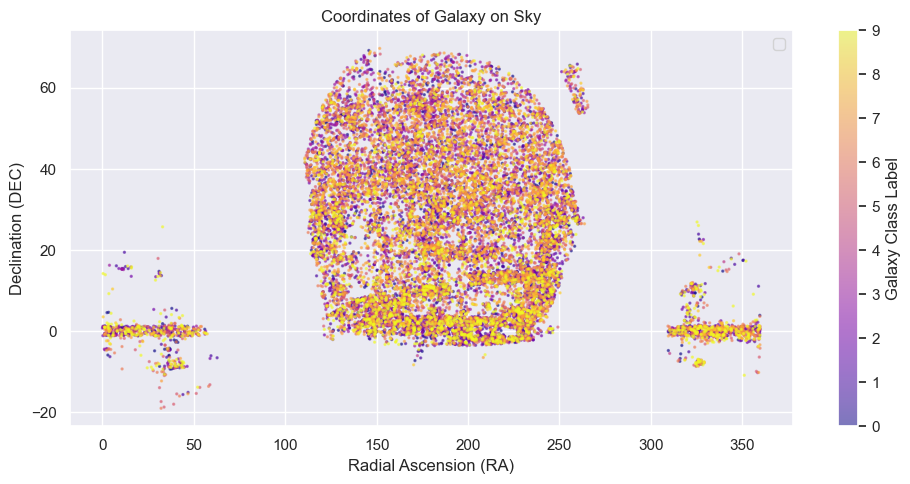

In [49]:
plt.figure(figsize = (10,5))
plt.scatter(ra, dec, c = label, s = 2, cmap = 'plasma', alpha = .5)
cb = plt.colorbar() 
cb.set_label('Galaxy Class Label') 
plt.title("Coordinates of Galaxy on Sky")
plt.xlabel("Radial Ascension (RA)")
plt.ylabel("Declination (DEC)")
plt.legend()
plt.tight_layout()
plt.savefig('../../plots/RADEC.png', bbox_inches='tight')

Text(0.5, 1.0, 'Galaxy Classes Abundance')

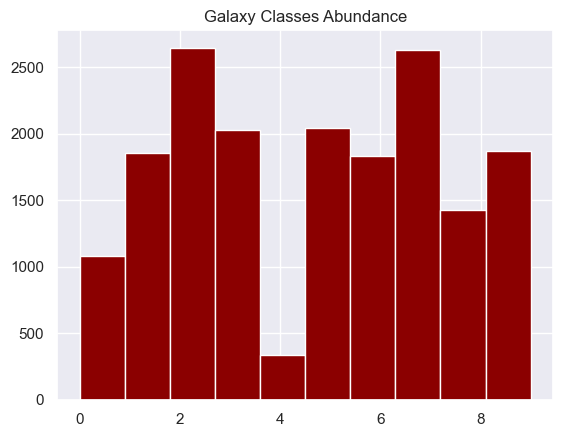

In [61]:
plt.hist(label, color = 'darkred')
plt.title('Galaxy Classes Abundance')

Seems like we are severely lacking labels in 4 (Cigar Shaped Smooth Galaxies). We can omit these

In [62]:
labels = [x for x in label if x!=4]

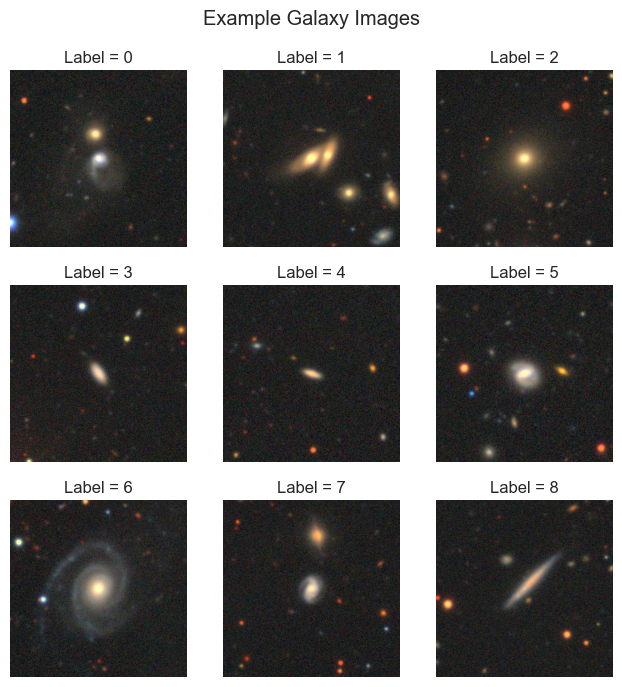

In [100]:
fig = plt.figure(figsize=(7,7))
for i in range(3*3):
    fig.suptitle('Example Galaxy Images')
    ax = fig.add_subplot(3,3, i+1)
    ax.axis('off')
    idx = np.where(label == i)[0][1]
    plt.imshow(images[idx])
    plt.grid(None)
    plt.tight_layout()
    plt.title(f'Label = {label[idx]}')
plt.savefig('../../plots/galaxies.png')
